In [2]:
import time
import toml
import numpy as np
import matplotlib.pyplot as plt
from ref_trajectory import generate_trajectory as traj
%matplotlib inline

There are a lot of configuration parameters. It is a good idea to separate it from the main code. At some point you will be doing parameter tuning. 

We will use toml format to store parameters. Open config.toml and go over the description of the different parameters we may use here

Read the config parameters, default output is a dictionary. You have to then store them as local variables. 
You have 2 options for this
1. update locals() directly - a little bit dangerous
2. You can use itemgetter

In [3]:
config_params = toml.load("config.toml")['params']
print(config_params)
locals().update(config_params)
print(dt, V_MAX)

{'dt': 0.1, 'V_MAX': 1.2, 'W_MAX': 1.0, 'K_MAX': 0.5, 'MIN_DIST': 1.0, 'ACC_MAX': 0.5, 'W_DOT_MAX': 3.0, 'LATERAL_ACC_MAX': 1.5, 'goal_threshold': 0.05, 'pred_horizon': 10, 'w_cte': 1.0, 'w_speed': 1.0}
0.1 1.2


There are 3 functions we need to write for DWA

1. Simulate unicyle - we will slightly modify it to simulate $N$ steps 

2. Command Window - Entire set of acceptable $(v, \omega)$ in that time instant given current $(v, \omega)$$

3. track - get $(v, \omega )$ for path with the lowest cost

In the first iteration, let us not integrate collision checking. Let us integrate these pieces, make sure DWA works for a few paths!

In [4]:
""" 
The code to generate the different pairs given the suitable v,w values computed
This is the same example used as in the theory lectures                         
"""
v_min, v_max = 0.9, 1.1
w_min, w_max = -0.1, 0.1
vs = np.linspace(v_min, v_max, num=5)
ws = np.linspace(w_min, w_max, num=5)
cmd = np.transpose([np.tile(vs, len(ws)), np.repeat(ws, len(vs))])
# print(cmd)
# print(cmd.shape)

Lets define our grid

In [5]:
class Lidar(object):
    def __init__(self, nbeams=8, fov=70, max_dist=5.0, sampling_pts=20):
        #nbeams = number of sensing beams
        #FOV = field-of-view of Lidar/ coverage in degrees
        #max_dist = maximum distance Lidar can sense
        #sampling_pts = num pts on a given beam for obstacle check
        self.beam_angles = np.deg2rad(np.linspace(-fov/2+np.pi/2,fov/2+np.pi/2,num=nbeams))
        self.line_sampler = max_dist * np.linspace(0, 1, num=sampling_pts)
    
    def set_env(self, grid, grid_res=0.05):
        #2-D occupancy grid and grid_resolution
        self.grid = grid
        self.grid_res = grid_res
    
    def sense_obstacles(self, pose):
        xc, yc, theta = pose
        beam_data = []
        for b in self.beam_angles:
            direction = np.array([np.cos(theta+b), np.sin(theta+b)])
            for d in self.line_sampler:
                beam_x, beam_y = np.array([xc, yc]) + d * direction
                i, j = int(beam_x/self.grid_res), int(beam_y/self.grid_res)
                if self.grid[i][j] == 1:
                    break
            beam_data.append(d)
        return beam_data

In [6]:
r = 0.15
l = 0.15
# circles = (x coordinate, y coordinate, radius)
circles = [(0, 0, r), (0, l, r), (0, -l, r)]

def circle_collision_check(grid, local_traj):
    xmax, ymax = grid.shape
    all_x = np.arange(xmax)
    all_y = np.arange(ymax)
    X, Y = np.meshgrid(all_x, all_y)
    for xl, yl, tl in local_traj:
      rot = np.array([[np.sin(tl), -np.cos(tl)],
                      [np.cos(tl),  np.sin(tl)]])   # Rotational matrix
      for xc, yc, rc in circles:
        xc_rot, yc_rot = rot @ np.array([xc, yc]) + np.array([xl, yl])
        xc_pix, yc_pix = int(xc_rot/grid_res), int(yc_rot/ grid_res)   # Get the actual coordinates
        rc_pix = (rc/ grid_res)
        inside_circle = ((X-xc_pix)**2 +(Y-yc_pix)**2 - rc_pix**2 < 0)   # Return points within the radii of the vehicle
        occupied_pt = grid[X, Y] == 1   # Get all the occupied points
        if np.sum(np.multiply( inside_circle, occupied_pt)):   # Check if those points within the radii contain any obstacles
          return True
    return False

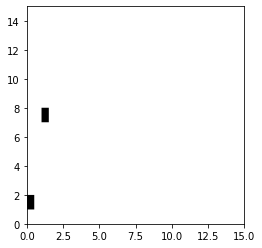

In [7]:
#custom grid
#choose resolution and dimensions
grid_res = 0.05
grid_span =  15 # square circuit dimensions in m

#calculate grid_shape from grid
# dimensions have to be integers
grid_shape = (np.array([grid_span]*2)/grid_res).astype('int')
#Initialize 
# Let 1 mean occupied, 0 mean unnoccupied
grid_data = np.zeros(grid_shape)   # Set entire map as unoccupied

#Create rectangular obstacles in world co-ordinates
#xmin, xmax, ymin, ymax
obstacles = np.array([[0,0.5 , 1, 2],
                      [1, 1.5, 7, 8]]) 

# obstacles = np.array([[1, 1.5, 7, 8]])   # Curved path obstacle
# obstacles = np.array([[0,0.5 , 1, 2]])   # Straight line obstacle
# Walls near the bot:
# obstacles = np.array([[0.25, 1.5, 1, 5]])

# obstaclescc= np.array([[]])
for obs in obstacles:
    # calculate obstacles extent in pixel coords
    xmin, xmax, ymin, ymax = (obs/grid_res).astype('int')
    # mark them as occupied
    grid_data[xmin:xmax ,ymin:ymax ] = 1.0   

#calculate the extents    
x1, y1 = 0, 0
x2, y2 = grid_span, grid_span

#imshow() from prior cell
plt.figure()
plt.imshow(1-grid_data.T, origin='lower', cmap=plt.cm.gray, extent=[x1,x2,y1,y2] )
# plt.plot(local_traj[:,0], local_traj[:,1])

In [8]:
def simulate_unicycle(pose, v,w, N=1, dt=0.1):
    x, y, t = pose
    poses = []
    for _ in range(N):
        x += v*np.cos(t)*dt
        y += v*np.sin(t)*dt
        t += w*dt
        poses.append([x,y,t])   
    return poses

In [9]:
# Increasing these values for faster turn rate
W_MAX = 1.2 
W_DOT_MAX = 5
K_MAX = 5

# commands = command_window(1, 0)
# print(commands)

In [11]:
def command_window(v, w, dt=0.1):
    """Returns acceptable v,w commands given current v,w"""
    
    # velocity can be (0, V_MAX)
    # ACC_MAX = max linear acceleration
    v_max = min(V_MAX, v + ACC_MAX*dt)   
    # above statement returns velocity after 0.1s with acc =  ACC_MAX, provided returned velocity < V_MAX, otherwise returns V_MAX
    v_min = max(0, v - ACC_MAX*dt)   
    # above statement returns velocity after 0.1s with deacc =  ACC_MAX, provided returned velocity > 0, otherwise returns 0

    # omega can be (-W_MAX, W_MAX)
    #W_DOT_MAX = max angular acceleration
    w_max = min(W_MAX, w + W_DOT_MAX*dt)
    w_min = max(-W_MAX, w - W_DOT_MAX*dt)
    
    #generate quantized range for v and omega
    vs = np.linspace(v_min, v_max, num=10)
    ws = np.linspace(w_min, w_max, num=20)

    #cartesian product of [vs] and [ws]
    #remember there are 0 velocity entries which have to be discarded eventually
    commands = np.transpose([np.tile(vs, len(ws)), np.repeat(ws, len(vs))])   # Cartesian product
    
    #calculate kappa for the set of commands  (w/v)
    epsilon = 1e-6
    #       (   w_values  ) / (     v_values + epsilon)
    kappa = (commands[:,1]) / (commands[:,0] + epsilon)  
    # epsilon is added to get rid of zero error, ie when v = 0, w/v is undefined 
    
    #returning only commands < max curvature 
    return commands[(kappa < K_MAX) & (commands[:, 0] != 0)]

In [14]:
buffer = 0
lidar = Lidar(max_dist= 0.85)
lidar.set_env(grid_data)

def track(ref_path, pose, v, w, dt=0.1):
    global collision_check
    commands = command_window(v, w, dt)
    # Get distances of obstacles from lidar
    dist = lidar.sense_obstacles(pose=pose)

    # print(dist[:4])   # -ve w distances
    neg_w_distances = np.sum(dist[:4])/4
    # print(f"negative distances: {neg_w_distances}")

    # print(dist[4:])   # +ve w distances
    pos_w_distances = np.sum(dist[4:])/4
    # print(f"positive distances: {pos_w_distances}")

    # Heuristic cost is the difference between average of positive half and negative half distances returned from the lidar
    heuristic_cost = np.abs(pos_w_distances - neg_w_distances)
    # heuristic_cost = 0
    # print(f"heuristic_cost = {heuristic_cost}")

    # Choose to favour +ve w or -ve w paths based on the side which gives higher average distance 
    if pos_w_distances > neg_w_distances: 
      # heuristic_cost = pos_w_distances - neg_w_distances
      # print("positive values are greater")
      collision_check = True
      pos_w, neg_w = True, False

    if neg_w_distances > pos_w_distances: 
      # heuristic_cost = neg_w_distances - pos_w_distances
      # print("negative values are greater")
      collision_check = True
      pos_w, neg_w = False, True

    if neg_w_distances == pos_w_distances:
      # heuristic_cost = 0
      collision_check = False
      pos_w, neg_w = False, False

    
    print(f"\n Tracked point: {np.round(ref_path[-1][0])}, {np.round(ref_path[-1][1], 2)}")   # Print which point is being tracked
    # global grid_data
    #initialize path cost
    cte = np.inf
    best_cost, best_command = np.inf, None
    for i, (v, w) in enumerate(commands):
        # print(f"{i+1}")
        # print(f"v, w = {np.round(v,3)}, {np.round(w,3)}")
        local_path = simulate_unicycle(pose, v, w, pred_horizon + buffer)   # Number of steps = prediction horizon + buffer
        final_x, final_y = local_path[-1][0], local_path[-1][1]   # Get last position
        # plt.plot(final_x, final_y, '.')

        if collision_check:
          if circle_collision_check(grid_data, local_path): #ignore colliding paths
              # print("  local path has a collision \n")
              continue

        # calculate cross-track error
        # can use a simplistic definition of how close is the last pose in local path from the ref path
        # for x, y,_ in ref_path:
        #   point_dist = np.sqrt((x-local_path[-1][0])**2 + (y-local_path[-1][1])**2)
        #   if point_dist < cte: 
        #     cte = point_dist
        #     tracked_x, tracked_y = x, y
        #   else: continue
        # print(f"tracked: {tracked_x}, {tracked_y}")

        # closest_pt = np.argmin(np.hypot(ref_path[:path_index] - local_path[-1]))
        # print(f"  closest point: {closest_pt}")

        # Calculate distance between final ref_path point and final local_path point
        cte = np.sqrt((ref_path[-1][0]-local_path[-1][0])**2 + (ref_path[-1][1]-local_path[-1][1])**2)
        # print(f"  Cross Track Error: {cte}")
        
        # heuristic_cost = np.sqrt((tracked_x-local_path[-1][0])**2 + (tracked_y-local_path[-1][1])**2)
        # other cost functions are possible
        # can modify collision checker to give distance to closest obstacle

        if neg_w and w >= 0:
          cost = w_cte*cte + w_speed*(V_MAX - v)**2  + heuristic_cost
          # print("  added heuristic")

        elif pos_w and w <= 0:
          cost = w_cte*cte + w_speed*(V_MAX - v)**2  + heuristic_cost
          # print("  added heuristic")
        
        else:
          cost = w_cte*cte + w_speed*(V_MAX - v)**2
        #   print("  no heuristic")

        # print(f"  Cost: {cost}")
        # print(f"  final position: {np.round(final_x,3)}, {np.round(final_y,3)} \n")
        #check if there is a better candidate
        if abs(w) < 0.05: w = 0
        if cost <= best_cost:
            best_cost, best_command, sl = cost, [v, w], i+1

    # print("tracking x = ", np.round(tracked_x, 2))
    # print("tracking y = ", np.round(tracked_y, 2))
    # print(f"\nBest cost: {np.round(best_cost,3)}")
    # print(f"Best command: {best_command}")
    # print(f"iteration: {sl}")
    # print(f"Beam distances: {dist}")
    if best_command:
        return best_command
    else:
        return [0, 0]
    # return best_command

In [15]:
start_pose = [0, 0, np.pi/2]
route = [("straight", 5),("turn", -90),("straight", 6),("turn", 90)]
ref_path = traj(route, start_pose).T

# Obtain final point for collsion avoidance
final_x, final_y = ref_path[-1][0], ref_path[-1][1]
goal_index, path_index = 5, 0
pose = start_pose
logs = []
v_tracker, w_tracker = [], [] 
v, w = 0.0, 0.0
iterations = 1
iter_time = 0
collision_check = False
# error_correction = 10

while np.sqrt((ref_path[-1][0]-pose[0])**2 + (ref_path[-1][1]-pose[1])**2) > goal_threshold*2:
    if collision_check: error_correction = 25
    else: error_correction = 15

    print(f"iteration: {iterations}")
    t0 = time.time()
    if len(ref_path) <= goal_index:
      # print("true")
      local_ref_path = ref_path

    else:
      local_ref_path = np.round(ref_path[path_index:path_index+goal_index], 3)
      curr_x, curr_y = pose[0], pose[1]
      local_x, local_y = local_ref_path[-1][0], local_ref_path[-1][1]
      # update path_index using current pose and local_ref_path
      if np.sqrt((local_x-curr_x)**2 + (local_y-curr_y)**2) < goal_threshold*error_correction and path_index != len(ref_path)-1:
        path_index = path_index + 1

     
    # get next command
    v, w = track(local_ref_path, pose, v, w)
    v_tracker.append(v)
    w_tracker.append(w)
    
    #simulate vehicle for 1 step
    # remember the function now returns a trajectory, not a single pose
    pose = simulate_unicycle(tuple(pose), v, w)
    pose = pose[0]

    print(f" {np.round(pose[0],2)}, {np.round(pose[1],2)}, {np.round(pose[2], 2)} ")

    #update logs
    logs.append([*pose, v, w])
    t1 = time.time() #simplest way to time-profile your code
    print(f"idx:{path_index}, v:{v:0.3f}, w:{w:0.3f}, time:{(t1-t0) * 1000:0.1f}ms \n")
    iter_time = iter_time + (t1-t0)
    iterations = iterations+1

print(f"average time for 1 iteration: {np.round(iter_time/iterations,5)} s")
print(f"Total time for simulation: {iter_time} s")

iteration: 1

 Tracked point: 0.0, 2.22
 0.0, 0.01, 1.57 
idx:0, v:0.050, w:0.000, time:8.1ms 

iteration: 2

 Tracked point: 0.0, 2.22
 0.0, 0.02, 1.57 
idx:0, v:0.100, w:0.000, time:8.8ms 

iteration: 3

 Tracked point: 0.0, 2.22
 0.0, 0.03, 1.57 
idx:0, v:0.150, w:0.000, time:11.4ms 

iteration: 4

 Tracked point: 0.0, 2.22
 0.0, 0.05, 1.57 
idx:0, v:0.200, w:0.000, time:11.9ms 

iteration: 5

 Tracked point: 0.0, 2.22
 0.0, 0.08, 1.57 
idx:0, v:0.250, w:0.000, time:11.8ms 

iteration: 6

 Tracked point: 0.0, 2.22
 0.0, 0.11, 1.57 
idx:0, v:0.300, w:0.000, time:11.8ms 

iteration: 7

 Tracked point: 0.0, 2.22
 0.0, 0.14, 1.57 
idx:0, v:0.350, w:0.000, time:12.7ms 

iteration: 8

 Tracked point: 0.0, 2.22
 0.0, 0.18, 1.57 
idx:0, v:0.400, w:0.000, time:13.9ms 

iteration: 9

 Tracked point: 0.0, 2.22
 0.0, 0.23, 1.57 
idx:0, v:0.450, w:0.000, time:13.5ms 

iteration: 10

 Tracked point: 0.0, 2.22
 0.0, 0.28, 1.57 
idx:0, v:0.500, w:0.000, time:10626.7ms 

iteration: 11

 Tracked poin

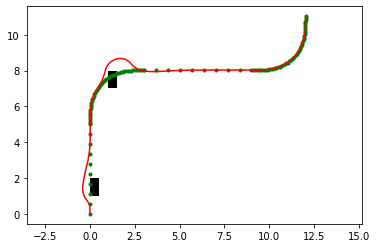

In [20]:
poses = np.array(logs)[:,:3]
plt.figure()
plt.axes().set_aspect('equal', 'datalim')
plt.plot(ref_path[:,0], ref_path[:,1], '.', c='g')
plt.plot(poses[:,0], poses[:,1], c='r')

# Plot obstacle
# Obstacle for straight path testing:
rectangle = plt.Rectangle((0,1), 0.5, 1, fc='black')   # [0,0.5 , 1, 2]
plt.gca().add_patch(rectangle)

# Obstacle for turn testing:
rectangle = plt.Rectangle((1, 7), 0.5, 1, fc='black')
plt.gca().add_patch(rectangle)

# Plot walls near bot
# obstacles = np.array([[0.5, 1.5, 1, 5]])
# rectangle = plt.Rectangle((0.25, 1),1, 4, fc='black')
# plt.gca().add_patch(rectangle)


Visualize curvature


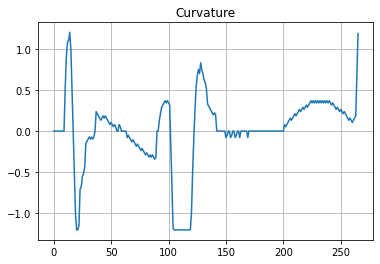

In [21]:
plt.figure()
plt.title('Curvature')
plt.plot(w_tracker)
plt.grid()